In [1]:
import warnings
import itertools

import pandas as pd
import numpy as np

import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

plt.style.use('bmh')

# **PART 1: Sales Forecast**

## **0. Loading datasets**

Load in the datesets of Tactor-Sales. Rewrite the indices to year-month-date

In [2]:
from io import StringIO
import requests

url = 'http://www.ucanalytics.com/blogs/wp-content/uploads/2015/06/Tractor-Sales.csv'
s = requests.get(url).text

sales_data = pd.read_csv(StringIO(s))
print(sales_data.shape)
sales_data.head(10)

(144, 2)


,Month-Year,Number of Tractor Sold
0,Jan-03,141
1,Feb-03,157
2,Mar-03,185
3,Apr-03,199
4,May-03,203
5,Jun-03,189
6,Jul-03,207
7,Aug-03,207
8,Sep-03,171
9,Oct-03,150


In [3]:
dates = pd.date_range(start = '2003-01-01', freq='MS', periods=len(sales_data))

In [4]:
sales_data['Months'] = dates.month
sales_data['Year'] = dates.year
sales_data.drop(['Month-Year'], axis = 1, inplace=True)

In [5]:
sales_data.rename(columns={'Number of Tractor Sold':'Tractor-Sales'}, inplace=True)
sales_data = sales_data[['Months', 'Year', 'Tractor-Sales']]
sales_data.set_index(dates, inplace=True)
sales_data

,Months,Year,Tractor-Sales
2003-01-01,1,2003,141
2003-02-01,2,2003,157
2003-03-01,3,2003,185
2003-04-01,4,2003,199
2003-05-01,5,2003,203
...,...,...,...
2014-08-01,8,2014,848
2014-09-01,9,2014,640
2014-10-01,10,2014,581
2014-11-01,11,2014,519


Text(0, 0.5, 'Tractor Sales')

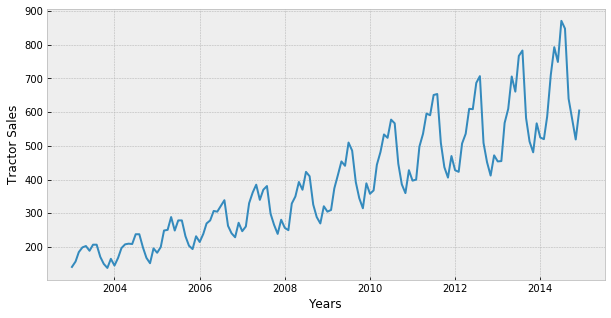

In [6]:
sales_ts = sales_data['Tractor-Sales']

plt.figure(figsize = (10,5))
plt.plot(dates, sales_ts)
plt.xlabel('Years')
plt.ylabel('Tractor Sales')

## 1. **Visualize Tractor Sales**

### **Time Series Decomposition**

- Trend
- Seasonality
- Remainder

(We don't consider business cycle here. In theory, business cycles in traditional businesses are observed over a period of 7 or more years. The unit we are considering here is relatively new.)

\begin{equation*}
Y_t = f(Trend_t, Seasonality_t, Remainder_t)
\end{equation*}

#### step 1.1 Trend

- observation: increasing overall with some seasonal variations.

Check stationarity:

- **Plot Rolling statsistics**: moving average or moving variance (all calculated according to the last 12 months stats)
\begin{equation*}
Moving Average = \frac{\sum_{i=-m}^m Y_{t+i}}{2m}
\end{equation*}
Take different time periods: 4, 6, 8, 12 months

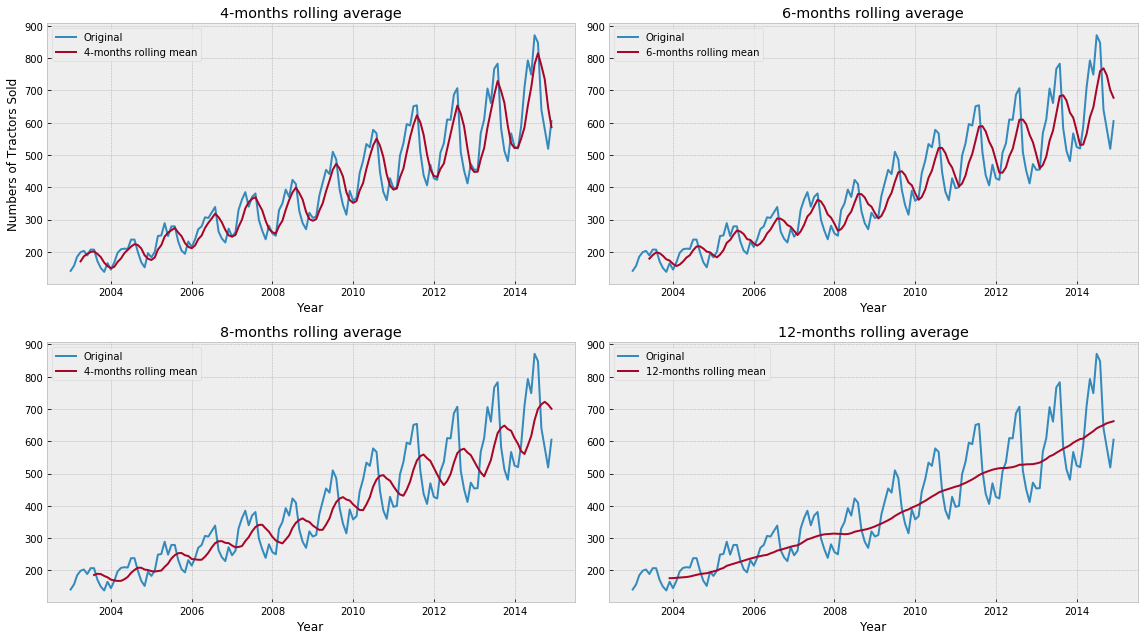

In [7]:
fig, axes = plt.subplots(2,2,sharey=False, sharex=False)
fig.set_figwidth(16)
fig.set_figheight(9)
axes[0][0].plot(sales_ts.index, sales_ts, label='Original')
axes[0][0].plot(sales_ts.index, sales_ts.rolling(window=4).mean(), label = '4-months rolling mean')
axes[0][0].set_xlabel("Year"), axes[0][0].set_ylabel('Numbers of Tractors Sold')
axes[0][0].legend(loc='best')
axes[0][0].set_title('4-months rolling average')
axes[0][1].plot(sales_ts.index, sales_ts, label='Original')
axes[0][1].plot(sales_ts.index, sales_ts.rolling(window=6).mean(), label = '6-months rolling mean')
axes[0][1].set_xlabel("Year"), axes[0][0].set_ylabel('Numbers of Tractors Sold')
axes[0][1].legend(loc='best')
axes[0][1].set_title('6-months rolling average')
axes[1][0].plot(sales_ts.index, sales_ts, label='Original')
axes[1][0].plot(sales_ts.index, sales_ts.rolling(window=8).mean(), label = '4-months rolling mean')
axes[1][0].set_xlabel("Year"), axes[0][0].set_ylabel('Numbers of Tractors Sold')
axes[1][0].legend(loc='best')
axes[1][0].set_title('8-months rolling average')
axes[1][1].plot(sales_ts.index, sales_ts, label='Original')
axes[1][1].plot(sales_ts.index, sales_ts.rolling(window=12).mean(), label = '12-months rolling mean')
axes[1][1].set_xlabel("Year"), axes[0][0].set_ylabel('Numbers of Tractors Sold')
axes[1][1].legend(loc='best')
axes[1][1].set_title('12-months rolling average')
plt.tight_layout()
plt.show()

**Observation**: 12-months rolling average is what we want: winkle-free. 

Plot standard deviation with 12-months rolling

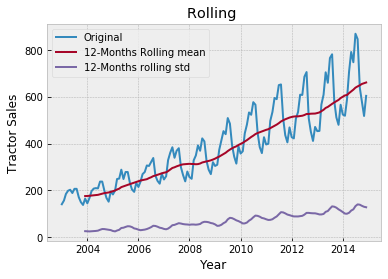

In [8]:
rolmean = sales_ts.rolling(window=12).mean()
rolstd = sales_ts.rolling(window=12).std()

sns.lineplot(sales_ts.index, sales_ts, label = 'Original')
sns.lineplot(sales_ts.index, rolmean, label = '12-Months Rolling mean')
sns.lineplot(sales_ts.index, rolstd, label = '12-Months rolling std')
plt.xlabel('Year'), plt.ylabel('Tractor Sales'), plt.title('Rolling ')
plt.legend(loc='best')
plt.show()

Check stationarity:

- **Dickey-Fuller Test**: this is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. 

    Test Results: a Test Statistic and some Critical Values for difference confidence levels. 
    
    If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

In [9]:
from statsmodels.tsa.stattools import adfuller
print('Results of the Dickey-Fuller Test:')
dftest = adfuller(sales_ts, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', ' #lags Used', 'Number of Observation Used'])
for key, value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of the Dickey-Fuller Test:
Test Statistic                  1.108825
p-value                         0.995291
 #lags Used                    14.000000
Number of Observation Used    129.000000
Critical Value (1%)            -3.482088
Critical Value (5%)            -2.884219
Critical Value (10%)           -2.578864
dtype: float64


**Conclusion in this step:** 

- rolling mean is clearly increasing with time and not a stationary series.
- Test Statistic is way more than the critical values

#### Step 1.2: Seasonality

First, turn the data into a monthly base. We will plot a statcked annual plot to observe the seasonality

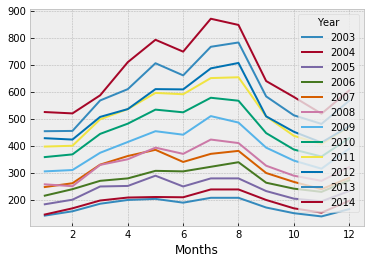

In [10]:
monthly_sales_data = pd.pivot_table(sales_data, values = 'Tractor-Sales', columns = 'Year', index = 'Months')
monthly_sales_data.plot()

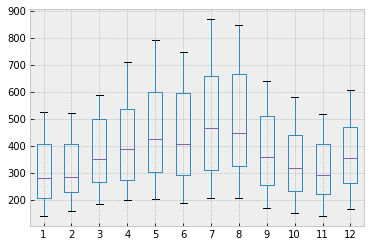

In [11]:
yearly_sales_data = pd.pivot_table(sales_data, values = 'Tractor-Sales', columns = 'Months', index = 'Year')
yearly_sales_data.boxplot()

**Inferences**

- The tractor sales increases every single year
- July and Aug are peaks for sales. Variance and Mean are also much higher.
- A seasonal effect with a cycle of 12 months: increasing trend in beginning of year and a drop trend at the end.


#### Step 1.3: Irregular Remainder

Multiplicative time series decomposition model:

\begin{equation*}
Y_t = Trend_t \times Seasonality_t \times Remainder_t
\end{equation*}


In [12]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model = 'multiplicative')

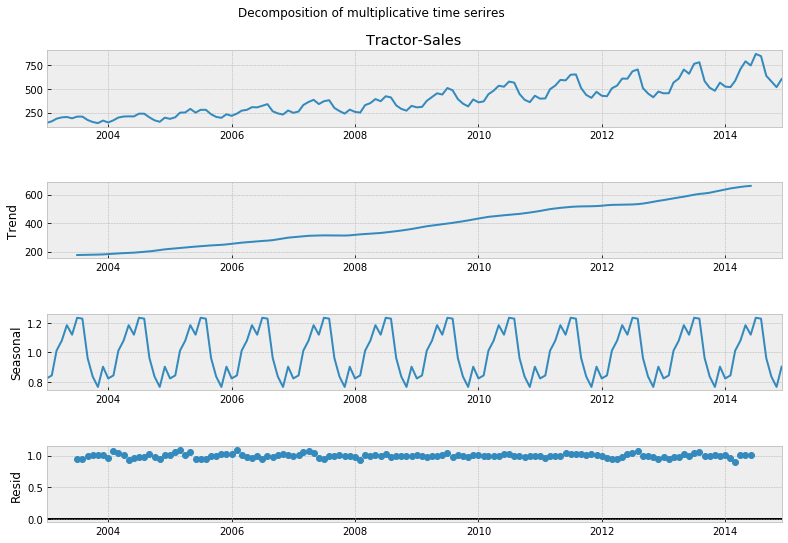

In [13]:
fig = decomposition.plot()
fig.set_figwidth(12)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time serires')
plt.show()

**Obaservations**:

1. **Trend**: 12-months moving average. Also looks like a straight line, so one could get similar result by linear regression.

2. **Seasonality**: fairly consistant month-on-month pattern. The monthly seasonal components are average values for a month after removal of trend

\begin{equation*}
Seasonality_t \times Remainder_t = \frac{Y_t}{Trend_t}
\end{equation*}

3. **Irregular Remainder (random)**: is the residual left in the series after removal of trend and seasonal components. The expectation from the remainder is look like a white noice, i.e. displays no pattern at all.

----------------------------------------------------------------------------------
## Introduction to ARIMA and White Noice

### **ARIMA**

**AR** (AutoRegressive), **I** (Intergrated), **MA** (Moving Average)

**ARIMA(p,d,q):** p, d q are the levels for each of the AR, I and MA parts

Goal: extract information in each step, to make the final residual display a white noise pattern.

**1. Integrated (I)** - subtract time series with its lagged series to extract tends

**Differencing** is a common technique for extraction of trends. The original series is subtracted with its lagged series:

No Differencing (d=0)  | $Y'_t = Y_t$

1st Differencing (d=1) | $Y'_t = Y_t - Y_{t-1}$

2nd Differencing (d=2) | $Y'_t = Y_t - Y_{t-1} - (Y_{t-1} - Y_{t-2}) = Y_t - 2 \times Y_{t-1} + Y_{t-2}$

Eample of d =1 :

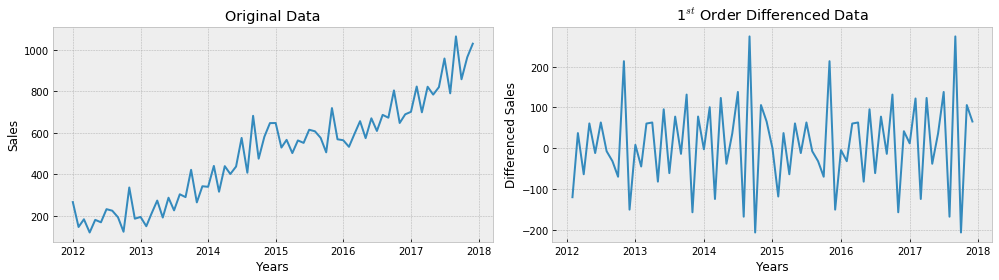

In [14]:
url = 'http://ucanalytics.com/blogs/wp-content/uploads/2017/08/dummy-sales.csv'
s = requests.get(url).text

random_df = pd.read_csv(StringIO(s))

random_df.set_index(pd.date_range(start='2012-01-01', freq='MS', periods=len(random_df)), inplace = True)

fig, axes = plt.subplots(1,2, sharex=False, sharey=False)
fig.set_figwidth(14)
fig.set_figheight(4)

axes[0].plot(random_df.index, random_df['Sales'])
axes[0].set_xlabel('Years')
axes[0].set_ylabel('Sales')
axes[0].set_title('Original Data')
axes[1].plot(random_df.index, random_df['Sales'].diff(periods=1))
axes[1].set_xlabel('Years')
axes[1].set_ylabel("Differenced Sales")
axes[1].set_title("1$^{st}$ Order Differenced Data")
plt.tight_layout()
plt.show()

- Above 1st differencing is written as ARIMA(0,1,0). MA and AR are not used here.
- In most cases (like above) the residual data after 1st differencing become trend-less.
- If the residual still has a trend we could do 2nd order differencing after 1st diff.

**2. AutoRegressive (AR)** - extract the influence of the previous periods' values on the current period

AR is performed after the time series data is made stationary.The influence is extracted by developing a regression model with the time lagged period values as independent or predictor variables.

$ARMIA(p,0,0): Y_t = c + \alpha_1Y_{t-1} + \alpha_2Y_{t-2} + \ldots + \alpha_pY_{t-p} + e_t$

**3. Moving Average (MA)** - extract the influence of the previous period's error terms on the current period's error

**IMPORTANT:**: this MA has nothing to do with the MA in the time series decomposition.

MA in ARIMA is developed with the multiple linear regression values with the lagged error values as independent or predictor variables. 

$ARIMA(0,0,p): Y_t = c + e_t + \beta_1e_{t-1} + \beta_2e_{t-2} + \ldots + \beta_qe_{t-q}$


### **White noice**

Human brains can be misleading: they are wired to find patterns. Therefore we need some mathematical methods to determine if the residual is white noice (i.e. no patterns at all).

**AutoCorrelation Function (ACF)**: finding correlation between a series of its lagged values.

- if lag is 0, then it has the perfect correlation i.e. $\rho = 1$

- White noise doesn't have a significant correalton with its historic values (lags >= 1)

Let's compare 2 cases: the original data and 1st differencing


<Figure size 432x288 with 0 Axes>

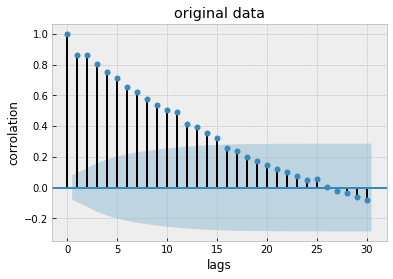

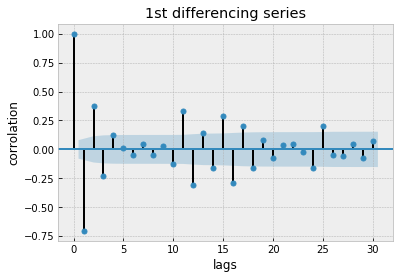

In [15]:
plt.figure()
smt.graphics.plot_acf(random_df['Sales'], lags=30, alpha=0.5)
plt.xlabel('lags')
plt.ylabel('corrolation')
plt.title('original data')

smt.graphics.plot_acf(random_df['Sales'].diff(periods=1).dropna(axis=0), lags=30, alpha=0.5)
plt.xlabel('lags')
plt.ylabel('corrolation')
plt.title('1st differencing series')
plt.show()

----------------------------------------------------------------------------------

## **2. Difference data to make data staionary on mean (remove trend)**

We observed that the tractor sales has an upward trend and a seasonal component that we have already analyzed.

We remove the upward trend with 1st order differencing

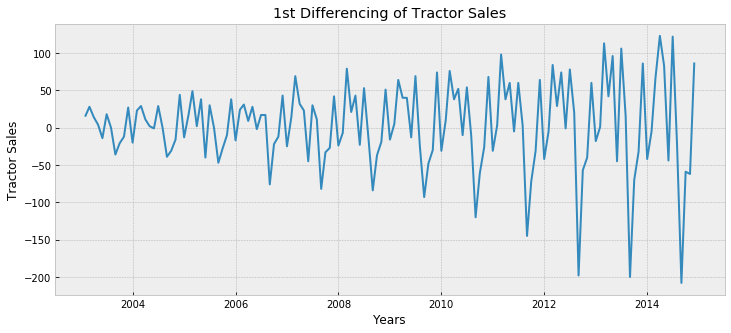

In [16]:
plt.figure(figsize=(12,5))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Tractor Sales')
plt.title('1st Differencing of Tractor Sales')
plt.show()

- This series is clearly not stationary on variance (it is increasing with time)
- Need to fix this problem to proceed with ARIMA.

**Solution:** one possible solution is **log transform** data to make data stationary on variance.
${Y_t}^{new} = log_{10}(Y_t)$



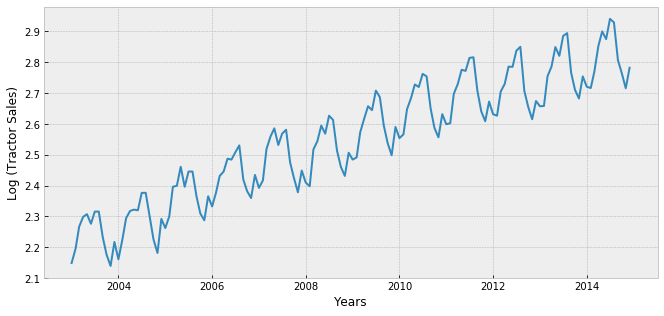

In [17]:
plt.figure(figsize=(11,5))
plt.plot(np.log10(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log (Tractor Sales)')
plt.show()

After this tranformation, notice that, the series is still not stationary on mean (since we are using the original data), but is stationary on variance now.

We can difference the log transformed data:

${Y_t}^{new} = log_{10}(Y_t) - log_{10}(Y_{t-1})$

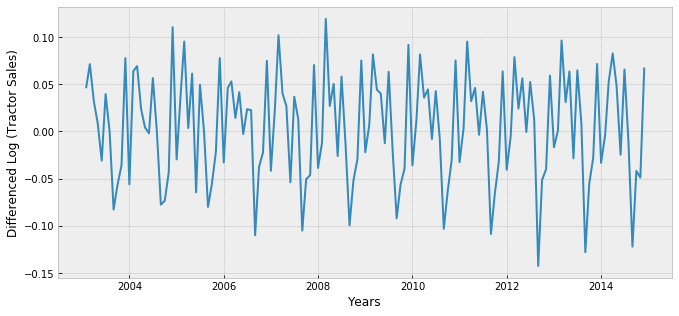

In [18]:
plt.figure(figsize=(11,5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Tractor Sales)')
plt.show()

Make some ACF and Partial ACF plots to identify patterns above.

The idea is to identify presence of AR and MA components in the residuals

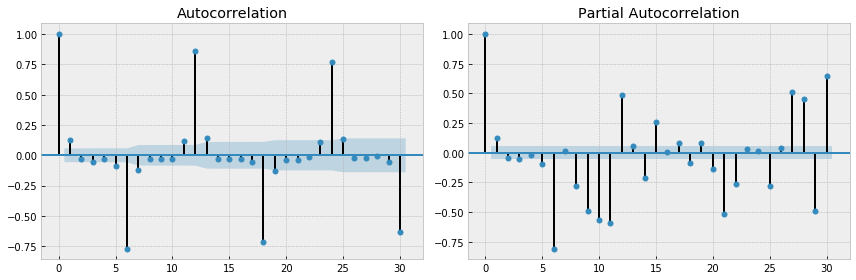

In [19]:
sales_ts_log = np.log10(sales_ts)
sales_ts_log.dropna(inplace=True)

sales_ts_log_diff = sales_ts_log.diff(periods=1)
sales_ts_log_diff.dropna(inplace=True)

fig, axes = plt.subplots(1,2,sharey=False, sharex=False)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(sales_ts_log_diff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(sales_ts_log_diff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

- enough spikes in the plots outside the insignificant zone
- residuals are not at random
- there is information that we can extract by AR and MA models
- there is a seasonal component available in the residual at the lag 12

## **3. Identification of Best FIt ARIMA model**

Before actaully using ARIMA, We need to find the optimal (p,d,q) that optimize a metric (e.g. AIC or BIC)

**Akaike Information Criterion (AIC)** - an effort to balance the model between goodness-of-fit and number of parameters used. Care about the max goodness of fit with min number of parameters.

$AIC = 2K - 2ln(L)$

- L: maximized value of the likelihood function representing goodness-of-fit
- K: number of estimated parameters
- want to keep AIC as low as possible

How? **Grid Search!**

In [20]:
p = d = q = range(0,2)

pdq = list(itertools.product(p,d,q))

seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]

In [21]:
import sys
warnings.filterwarnings('ignore')

best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

for param in pdq:
    for param_seasonal in seasonal_pdq:
        
        try:
            temp_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                                  order = param,
                                                  seasonal_order= param_seasonal,
                                                  enforce_stationarity=True,
                                                  enforce_invertibility = True)
            results = temp_model.fit()
            
            if results.aic < best_aic:
                best_aic = results.aic
                best_pdq = param
                best_seasonal_pdq = param_seasonal
            

        except:
            #pinrt("Unexpected error: ", sys.exc_info()[0])
            continue
print("Best SARIMAX {}x{} model - AIC: {}".format(best_pdq, best_seasonal_pdq, best_aic))
            

Best SARIMAX (0, 1, 1)x(1, 0, 1, 12) model - AIC: -733.7745886232603


**Best Model:**

Best SARIMAX $(0, 1, 1) \times (1, 0, 1, 12)$ model - AIC: -733.7745886232603

## **4. Predict Sales on in-sample data using best ARIMA**

In [22]:
best_model = sm.tsa.statespace.SARIMAX(sales_ts_log,
                                      order=(0,1,1),
                                       seasonal_order=(1,0,1,12),
                                       enforce_stationarity=True,
                                       enforce_invertibility=True)
best_results = best_model.fit()

In [23]:
print(best_results.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      Tractor-Sales   No. Observations:                  144
Model:             SARIMAX(0, 1, 1)x(1, 0, 1, 12)   Log Likelihood                 370.887
Date:                            Thu, 01 Jul 2021   AIC                           -733.775
Time:                                    10:23:33   BIC                           -721.923
Sample:                                01-01-2003   HQIC                          -728.959
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.3577      0.069     -5.202      0.000      -0.493      -0.223
ar.S.L12       0.9933      0.006   

In [24]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic = True, full_results = True)
pred_dynamic_ci = pred_dynamic.conf_int()

In [25]:
sales_ts_forecasted = pred_dynamic.predicted_mean
sales_ts_truth = sales_ts_log['2012-01-01':]

# Compute the mean square error
mse = ((sales_ts_forecasted - sales_ts_truth) ** 2).mean()
print('The Mean Squared Error of our forcasts is {}'.format(round(mse,4)))

The Mean Squared Error of our forcasts is 0.0011


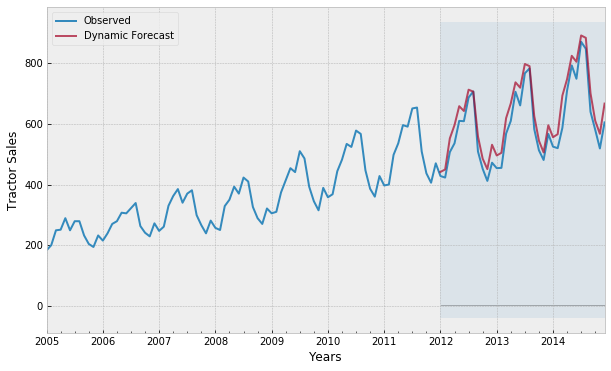

In [26]:
# plot!

axis = sales_ts['2005':].plot(label='Observed', figsize=(10,6))
np.power(10, pred_dynamic.predicted_mean).plot(ax=axis, label = 'Dynamic Forecast', alpha=0.7)
axis.fill_between(pred_dynamic_ci.index, pred_dynamic_ci.iloc[:,0], pred_dynamic_ci.iloc[:,1],color='k', alpha = 0.25)
axis.fill_betweenx(axis.get_ylim(),pd.to_datetime('2012-01-01'), sales_ts.index[-1],alpha=0.1, zorder=-1)
axis.set_xlabel('Years')
axis.set_ylabel('Tractor Sales')
plt.legend(loc='best')
plt.show()
plt.close()

## 5. Forecast sales using the best fit ARIMA model

Let's predict tractor sales for next 3 years, i.e. for 2015, 2016, 2017

In [27]:
n_steps = 36  # 3 years = 36 months
# alpha = 0.01 signifies 99% confidence interval
pred_uc_99 = best_results.get_forecast(steps = n_steps, alpha = 0.01)
# alpha = 0.05 signifies 95% confidence interval
pred_uc_95 = best_results.get_forecast(steps = n_steps, alpha = 0.05)


pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [30]:
idx = pd.date_range(sales_ts.index[-1], periods=n_steps, freq = 'MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10,pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]),
                    index=idx, columns = ['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10,pred_ci_99)]),
                    index=idx, columns = ['lower_ci_99', 'upper_ci_99'])
fc_all = pd.concat([fc_95, fc_99],axis=1)
fc_all.head(10)

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2014-12-01,567.466349,528.227249,609.620306,528.227249,609.620306
2015-01-01,566.212388,519.989326,616.544325,519.989326,616.544325
2015-02-01,668.857226,607.146431,736.840352,607.146431,736.840352
2015-03-01,755.217671,678.457865,840.661978,678.457865,840.661978
2015-04-01,850.236566,756.625614,955.429216,756.625614,955.429216
2015-05-01,812.413021,716.667785,920.949610,716.667785,920.949610
2015-06-01,931.159999,814.729581,1064.229118,814.729581,1064.229118
2015-07-01,927.060659,804.916362,1067.740085,804.916362,1067.740085
2015-08-01,700.888979,604.113563,813.167243,604.113563,813.167243
2015-09-01,625.720121,535.580948,731.029868,535.580948,731.029868


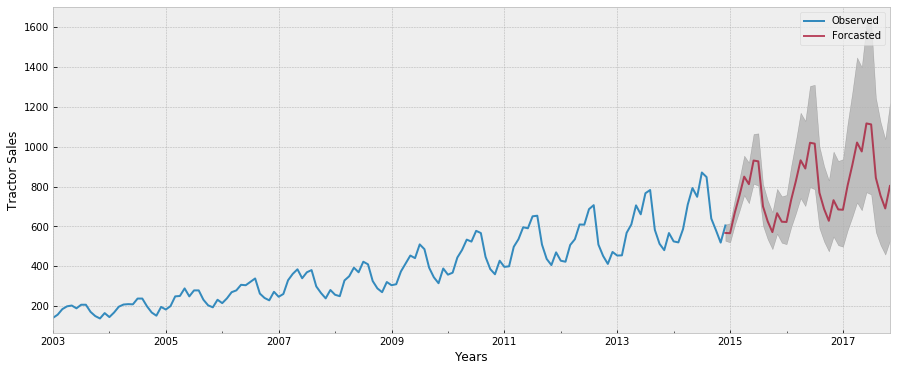

In [32]:
axis = sales_ts.plot(label = 'Observed', figsize=(15,6))
fc_all['forecast'].plot(label = 'Forcasted', alpha = 0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color = 'k', alpha = 0.2)
#axis.fill_between(fc_all.index, fc_all['lower_ci_99'], fc_all['upper_ci_99'], color = 'blueviolet', alpha = 0.2)
plt.legend(loc='best')
plt.xlabel('Years')
plt.ylabel('Tractor Sales')
plt.show()

## **6. Plot ACF and PACF for residuals to ensure no more information can be extracted**

The same procedure introduced before:

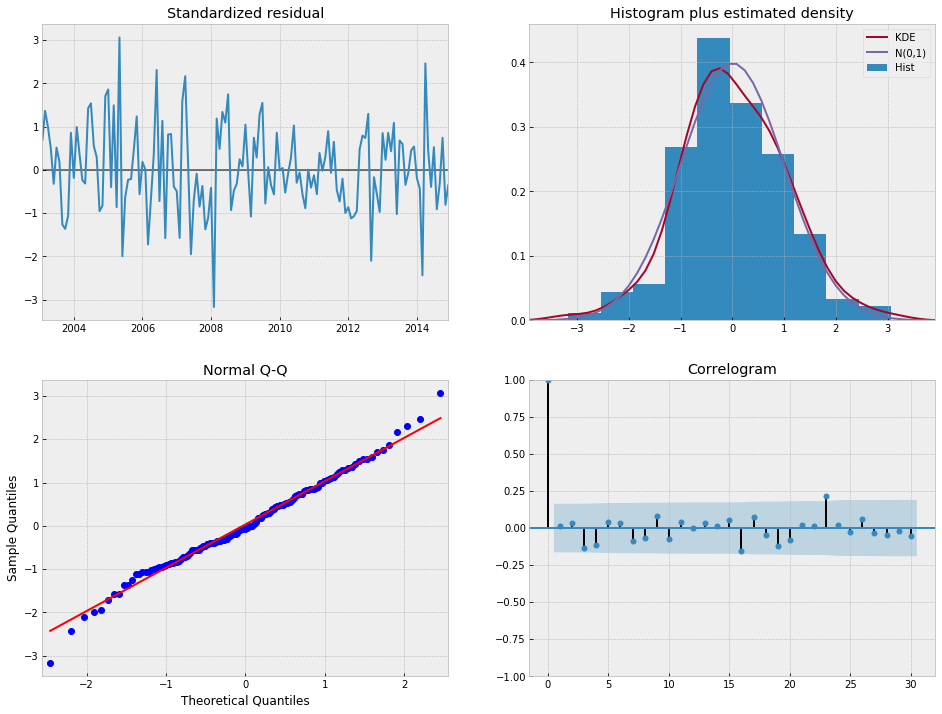

In [33]:
best_results.plot_diagnostics(lags = 30, figsize = (16,12))
plt.show()

**GOAL of this Investigation:** 

We need to ensure that the residuals of our model are: 
    
    1. uncorrelated
    2. normally distributed with zero mean
   
Otherwise, it means there are more information need to be extracted and we should improve our model.

Some analysis from the above diagnose plots:

- **KDE plot** (on the top right) suggests the residuals follow a distribution extremely close to normal with zero means
- **The qq-plot** (on the bottom left) shows that the distributions of residuals (i.e. the blue dots) follows a linear trend of the samples taken from a standard normal distribution. This is a strong indication that the residuals are normally distributed.
- **The residuals over time** (top left plot) don't display any patterns or seasonality, and appear to be white noise. This statement is confirmed by **the ACF plot** (bottom right), which shows that the time series residuals have low correlation with lagged version of itself.


All is saying that our ARIMA model seems good.

# **PART 2: Impact Analysis**

For the last 4 years, PowerHorse tractors is running an expensive marketing and farmer connect program to boost their sales. They are interested in learning **the impact of this program on overall sales**. As a data science consultant we are helping them with this effort. This is an interesting problem and requires a thorough analysis followed by creative solutions and scientific monitoring mechanism.

To begin with we will build models based on regression with ARIMA errors and compare them with the pure play ARIMA model. This analysis will provide some clues towards effectiveness of the marketing program. However, this analysis will not be conclusive for finding shortcomings and enhancements for the program which will require further analysis and creative solutions.



In [42]:
url = 'http://ucanalytics.com/blogs/wp-content/uploads/2017/08/sales-and-marketing.csv'
s = requests.get(url).text

mkt_sales_data = pd.read_csv(StringIO(s))
mkt_sales_data.set_index(pd.date_range(start='2011-01-01', freq='MS', periods = len(mkt_sales_data)), inplace =True)
mkt_sales_data.drop(['Time Period'], axis = 1, inplace=True)
mkt_sales_data.rename(columns={"Sales":"Tractor-Sales"}, inplace=True)
mkt_sales_data.head(5)

,Tractor-Sales,Marketing Expense
2011-01-01,397,486.64
2011-02-01,400,501.80
2011-03-01,498,437.09
2011-04-01,536,565.16
2011-05-01,596,744.15


To begin with, make some plots:

- a scatter plot of Tractor-Sales vs Marketing Expense

Notice, we usually don't make a line plot if the 2 attributes are not in the same unit.

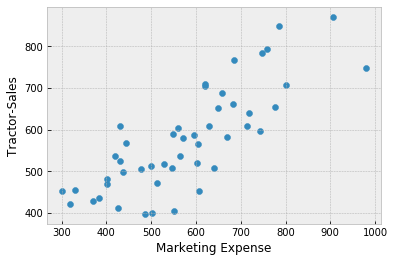

In [46]:
plt.figure()
plt.scatter(mkt_sales_data['Marketing Expense'], mkt_sales_data['Tractor-Sales'])
plt.xlabel('Marketing Expense')
plt.ylabel('Tractor-Sales')
plt.show()

In [50]:
print("Correlation for marketing data: {}".format(round(mkt_sales_data.corr()['Tractor-Sales']['Marketing Expense'], 3)))

Correlation for marketing data: 0.801


Looks promising with quite a high correlation coefficient ( $ \rho  > 0.8$ ). **However, there is a lurking danger in analyzing non-stationary time series data.** Since two uncorrelated series can display high correlation because of time series trend in data. In this case, PowerHorse is a growing company and the latent factor is 'growth' of the company. Hence both its sales and marketing expenses can be on an upward curve independent of each other. 

To investigat that a better way is to **find the correlation between stationary data obtained through differencing of marketing expediture and the trator sales data individually**.

The following is the correlation plot for stationary data:

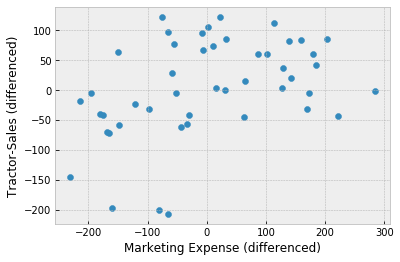

In [68]:
mkt_sales_data_diff = mkt_sales_data.diff(periods=1)
mkt_sales_data_diff.dropna(inplace=True)

plt.figure()
plt.scatter(mkt_sales_data_diff['Marketing Expense'], mkt_sales_data_diff['Tractor-Sales'])
plt.xlabel('Marketing Expense (differenced)')
plt.ylabel('Tractor-Sales (differenced)')
plt.show()

In [76]:
print("Correlation for differenced marketing data: {}".format(round(mkt_sales_data_diff.corr()['Tractor-Sales']['Marketing Expense'], 3)))

Correlation for differenced marketing data: 0.411


$\rho$ suddenly dropped to 0.411! Thought there is still some correlation in the data.

On the other hand, typically the marketing effort for the previous few months needs to have a good correlation with the sales for an effective marketing program. Let's see if that is the case:

In [71]:
# create a new df
n = len(mkt_sales_data_diff)

prev_mth_corr_data = pd.DataFrame(np.column_stack((mkt_sales_data_diff['Marketing Expense'][0:n-1].values, mkt_sales_data_diff['Tractor-Sales'][1:n].values)
                                    ), columns = ["Previous Month's Differenced Marketing expense",'Differenced Tractor Sales'])

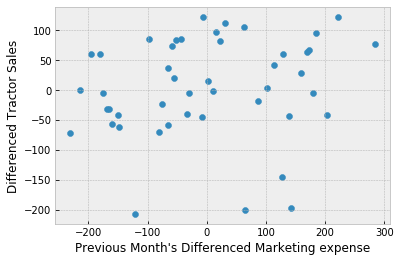

In [71]:
plt.figure()
plt.scatter(prev_mth_corr_data['Previous Month\'s Differenced Marketing expense'], prev_mth_corr_data['Differenced Tractor Sales'])
plt.xlabel('Previous Month\'s Differenced Marketing expense')
plt.ylabel('Differenced Tractor Sales')
plt.show()

In [75]:
print(
    "Correlation of current Months's Differenced Tractor Sales with Previous Month's Differenced Marketing Expense: {}"\
    .format(round(prev_mth_corr_data.corr().iloc[0,1], 2)))

Correlation of current Months's Differenced Tractor Sales with Previous Month's Differenced Marketing Expense: 0.17


$\rho = 0.171$! The marketing expense of previous month has very little correlation with Tractor Sales!

Maybe we can investigate more into the correlation between the previous n months (say n<=4) and the (diffed) tractor sales? But the correlation for the previous quarter also shows non-existent correlation with sales. 

Let’s build a regression model with ARIMA error (ARIMAX) model for the current and previous months.

In [84]:
lagged_mkt_exp_diff_sales_data = pd.DataFrame(np.column_stack((
                                            mkt_sales_data_diff['Marketing Expense'],\
                                            mkt_sales_data_diff['Marketing Expense'].shift(periods=1)[0:n],
                                            mkt_sales_data_diff['Marketing Expense'].shift(periods=2)[0:n],
                                            mkt_sales_data_diff['Marketing Expense'].shift(periods=3)[0:n],
                                            mkt_sales_data_diff['Tractor-Sales'][0:n].values)),
                                            columns=["Diff_Mkt_Exp", "Diff_Mkt_Exp_Lag_1", "Diff_Mkt_Exp_Lag_2", "Diff_Mkt_Exp_Lag_3", "Diff_Sales"])
lagged_mkt_exp_diff_sales_data.set_index(mkt_sales_data_diff.index, inplace = True)
lagged_mkt_exp_diff_sales_data.head(10)

,Diff_Mkt_Exp,Diff_Mkt_Exp_Lag_1,Diff_Mkt_Exp_Lag_2,Diff_Mkt_Exp_Lag_3,Diff_Sales
2011-02-01,15.16,NaN,NaN,NaN,3.0
2011-03-01,-64.71,15.16,NaN,NaN,98.0
2011-04-01,128.07,-64.71,15.16,NaN,38.0
2011-05-01,178.99,128.07,-64.71,15.16,60.0
2011-06-01,-195.41,178.99,128.07,-64.71,-5.0
2011-07-01,101.47,-195.41,178.99,128.07,60.0
2011-08-01,127.30,101.47,-195.41,178.99,3.0
2011-09-01,-230.40,127.30,101.47,-195.41,-145.0
2011-10-01,-164.30,-230.40,127.30,101.47,-72.0
2011-11-01,168.75,-164.30,-230.40,127.30,-31.0


We now want to create different by considering the different lagged marketing expenditure attributes as regressors and investigate whether previous motnh's/quarter's affect the tractor sales or not (in other words if we incoporate the marketing efforts does they lower the AIC score or not. We would be building 4 ARIMA models with regressors ranging from current month to last quarter)

In [118]:
import sys
warnings.filterwarnings('ignore')

def auto_arima(timeSeries, regressor=None, p=range(0,2), d=range(0,1), q=range(0,2)):

    pdq = list(itertools.product(p,d,q))

    seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p,d,q))]
    
    warnings.filterwarnings('ignore')
    
    best_aic = np.inf
    best_pdq = None
    best_seasonal_pdq = None
    best_results = None
    
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                temp_model = sm.tsa.statespace.SARIMAX(endog=timeSeries,
                                                  exog=regressor,
                                                  order = param,
                                                  seasonal_order= param_seasonal,
                                                  enforce_stationarity=True,
                                                  enforce_invertibility = True)
                temp_results = temp_model.fit()
                if temp_results.aic < best_aic:
                    best_aic = temp_results.aic
                    best_pdq = param
                    best_seasonal_pdq = param_seasonal
                    best_results = temp_results

            except:
                print("Unexpected error: ", sys.exc_info()[0])
                continue
    
    print("Best SARIMAX {}x{} model - AIC: {}".format(best_pdq, best_seasonal_pdq, best_aic))
    print(best_results.summary())

In [119]:
# ARIMA model with no regressor
X = lagged_mkt_exp_diff_sales_data['Diff_Mkt_Exp'][3:47]
y = lagged_mkt_exp_diff_sales_data['Diff_Sales'][3:47]
auto_arima(y, X)

Best SARIMAX (0, 0, 1)x(1, 0, 0, 12) model - AIC: 443.2544478059975
                                      SARIMAX Results                                      
Dep. Variable:                          Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                -217.627
Date:                             Thu, 01 Jul 2021   AIC                            443.254
Time:                                     15:24:23   BIC                            450.391
Sample:                                 05-01-2011   HQIC                           445.901
                                      - 12-01-2014                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Diff_Mkt_Exp     0.0233      0.039

In [121]:
# ARIMA model with 1 month Lag Marekting Sales Data Regressor
X = lagged_mkt_exp_diff_sales_data[['Diff_Mkt_Exp','Diff_Mkt_Exp_Lag_1']][3:47]
y = lagged_mkt_exp_diff_sales_data['Diff_Sales'][3:47]
auto_arima(y, X)

Best SARIMAX (0, 0, 1)x(1, 0, 0, 12) model - AIC: 445.140053440143
                                      SARIMAX Results                                      
Dep. Variable:                          Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                -217.570
Date:                             Thu, 01 Jul 2021   AIC                            445.140
Time:                                     15:41:52   BIC                            454.061
Sample:                                 05-01-2011   HQIC                           448.448
                                      - 12-01-2014                                         
Covariance Type:                               opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp           

In [122]:
# ARIMA model with 1 month Lag Marekting Sales Data Regressor
X = lagged_mkt_exp_diff_sales_data[['Diff_Mkt_Exp','Diff_Mkt_Exp_Lag_1','Diff_Mkt_Exp_Lag_2']][3:47]
y = lagged_mkt_exp_diff_sales_data['Diff_Sales'][3:47]
auto_arima(y, X)

Best SARIMAX (0, 0, 1)x(1, 0, 0, 12) model - AIC: 447.0778405052632
                                      SARIMAX Results                                      
Dep. Variable:                          Diff_Sales   No. Observations:                   44
Model:             SARIMAX(0, 0, 1)x(1, 0, [], 12)   Log Likelihood                -217.539
Date:                             Thu, 01 Jul 2021   AIC                            447.078
Time:                                     15:45:54   BIC                            457.783
Sample:                                 05-01-2011   HQIC                           451.048
                                      - 12-01-2014                                         
Covariance Type:                               opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp          

In [124]:
# ARIMA model with 1 month Lag Marekting Sales Data Regressor
X = lagged_mkt_exp_diff_sales_data[['Diff_Mkt_Exp','Diff_Mkt_Exp_Lag_1','Diff_Mkt_Exp_Lag_2','Diff_Mkt_Exp_Lag_3']][3:47]
y = lagged_mkt_exp_diff_sales_data['Diff_Sales'][3:47]
auto_arima(y, X)

Best SARIMAX (1, 0, 0)x(1, 0, 0, 12) model - AIC: 447.4032021513864
                                     SARIMAX Results                                      
Dep. Variable:                         Diff_Sales   No. Observations:                   44
Model:             SARIMAX(1, 0, 0)x(1, 0, 0, 12)   Log Likelihood                -216.702
Date:                            Thu, 01 Jul 2021   AIC                            447.403
Time:                                    15:48:15   BIC                            459.893
Sample:                                05-01-2011   HQIC                           452.035
                                     - 12-01-2014                                         
Covariance Type:                              opg                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Diff_Mkt_Exp           0.0111 

Now we compare AIC of our models:

In [138]:
results = pd.DataFrame([[443.254,445.140,447.078,447.403]],columns=['No Regressor',"1 Month Lag Regressor",'2 Month Lag Regressor','3 Month Lag Regressor'])
results.index = ['AIC']
results

,No Regressor,1 Month Lag Regressor,2 Month Lag Regressor,3 Month Lag Regressor
AIC,443.254,445.14,447.078,447.403


The above table shows that the AIC is increasing when we consider more monthe lag regressor. That saying, AIC, BIC value of plain ARIMA is lower than considering market expenses. It indicates that the marketing expenses are not helping increase the tracotr sales. This is the first indication for the management at PowerHorse to re-evaluate the marketing and farmer connect program.

#### **Important comment**:

evaluation of marketing budgets with a forecasting model like the one we have built is not the best of practices. The best practice is to embed scientific data collection, monitoring, and evaluation mechanism in the design of a marketing program at inception. However, a scientific and well thought out mechanism prior to implementation is often missing in many programs. This is when one could go back in time to use regression with ARIMA error to evaluate effective of marketing programs.